### [Udacity solution LunarLander DQN](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution)
### [Pytorch tutorial DQN CartPole](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

In [ ]:
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random
import fastprogress
from tqdm import tqdm_notebook as tqdm
from collections import namedtuple

import matplotlib.pyplot as plt
%matplotlib inline

print("Pytorch:     ", torch.__version__, "( GPU:", torch.cuda.is_available(),")")
print("OpenAi Gym:  ", gym.__version__)
print("Fastprogress:", fastprogress.__version__)

Pytorch:      1.3.1 ( GPU: False )
OpenAi Gym:   0.15.4
Fastprogress: 0.1.22


In [ ]:
torch.cuda.device_count()

0

In [ ]:
######################### Classic control
doblePendulo    = "Acrobot-v1"
paloBalanceado  = "CartPole-v1"
cocheColina     = "MountainCar-v0"
cocheColinaCont = "MountainCarContinuous-v0"
pendulo         = "Pendulum-v0"

######################### Box2D
BipedalWalker         = "BipedalWalker-v2"
BipedalWalkerHardcore = "BipedalWalkerHardcore-v2"
CarRacing             = "CarRacing-v0"
LunarLander           = "LunarLander-v2"
LunarLanderContinuous = "LunarLanderContinuous-v2"

In [ ]:
env = gym.make(LunarLander)
print("INPUT  (Observation): ", env.observation_space)
print("OUTPUT (Agent action):", env.action_space)

INPUT  (Observation):  Box(8,)
OUTPUT (Agent action): Discrete(4)


In [ ]:
print("\tmin:",env.observation_space.low)
print("\tmax:",env.observation_space.high)

	min: [-inf -inf -inf -inf -inf -inf -inf -inf]
	max: [inf inf inf inf inf inf inf inf]


In [ ]:
state = env.reset()

for _ in range(400):
    #env.render()
    action = env.action_space.sample() # your agent here (this takes random actions)
    state, reward, done, info = env.step(action)
    
    if done:
        state = env.reset()
env.close()

# LunarLander-v2 (Discrete)

### [Paper solution](https://www.researchgate.net/publication/333145451_Deep_Q-Learning_on_Lunar_Lander_Game)

### INPUT (8)

- Agent’s position $(x, y)$ in space
- Horizontal and vertical velocity ($v_x, v_y$)
- Orientation in space $\theta$
- Angular velocity $v_\theta$
- 2 bool flags indicating whether the left/right foot  is in contact with the ground.

### OUTPUT (4) (Discrete)
- `0`: Do nothing
- `1`: Fire left engine
- `2`: Fire down engine
- `3`: Fire right engine

### REWARD
- discounted
- cumulative
- From -300 to 300

![](https://miro.medium.com/max/740/1*i7lxpgt2K3Q8lgEPJu3_xA.png)

# Utils

In [ ]:
def copyNet(source, target):
    target.load_state_dict(source.state_dict())
    
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

# Agent (Neural Net)

In [ ]:
class Agent(nn.Module):

    def __init__(self, state_size, action_size, seed=0, fc1_units=64, fc2_units=64):
        super(Agent, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1  = nn.Linear(state_size, fc1_units)
        self.fc2  = nn.Linear(fc1_units, fc2_units)
        self.fc3  = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
    def chooseAction(self, stateNumpy):
        stateTensor   = torch.from_numpy(stateNumpy)
        actionsTensor = self.forward(stateTensor)
        return outputTensor.argmax().item()

policy_net = Agent(state_size=8, action_size=4).to(DEVICE) # Actor for compute rewards
target_net = Agent(state_size=8, action_size=4).to(DEVICE) # Learn from actor episodes
copyNet(source=policy_net, target=target_net)
target_net.eval()

############################ TEST AGENT
inputNumpy   = env.reset()
inputTensor  = torch.from_numpy(inputNumpy)#.unsqueeze(0).to(DEVICE)
outputTensor = policy_net(inputTensor)

print("INPUT (state):   ", inputTensor)
print("OUTPUT (actions):", outputTensor)
print("Selected output: ", outputTensor.argmax().item())

INPUT (state):    tensor([ 0.0032,  1.4043,  0.3213, -0.2930, -0.0037, -0.0728,  0.0000,  0.0000])
OUTPUT (actions): tensor([ 0.0874, -0.0445, -0.0489, -0.0419], grad_fn=<AddBackward0>)
Selected output:  0


# Memory
Stores the transitions that the agent observes, allowing us to reuse this data later.

In [ ]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward", "done"))


class PlayMemory(object):

    def __init__(self):
        #self.capacity = capacity
        #self.position = 0
        self.transitions = []

    def push(self, *args):
        #"""Saves a transition."""
        #if len(self.transitions) < self.capacity:
        #    self.transitions.append(None)
        #self.transitions[self.position] = Transition(*args)
        #self.position = (self.position + 1) % self.capacity
        self.transitions.append(Transition(*args))

    def sample(self, batch_size):
        sampleTransitions = random.sample(self.transitions, batch_size)
        states      = torch.from_numpy(np.vstack([t.state      for t in sampleTransitions if t is not None])).float().to(DEVICE)
        actions     = torch.from_numpy(np.vstack([t.action     for t in sampleTransitions if t is not None])).long().to(DEVICE)
        rewards     = torch.from_numpy(np.vstack([t.reward     for t in sampleTransitions if t is not None])).float().to(DEVICE)
        next_states = torch.from_numpy(np.vstack([t.next_state for t in sampleTransitions if t is not None])).float().to(DEVICE)
        dones       = torch.from_numpy(np.vstack([t.done       for t in sampleTransitions if t is not None]).astype(np.uint8)).float().to(DEVICE)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.transitions)

# Train

In [ ]:
EPISODES         = 200 # Number of training gameplays (2000)
MAX_ITER_EPISODE = 1000 # Max number of iterations per episode

BATCH_SIZE  = 64     # minibatch size
GAMMA = 0.99         # discount factor
TAU = 1e-3           # interpolation parameter for soft update of target parameters
LR = 5e-4            # learning rate 
TARGET_UPDATE = 4    # How often to update the target network (num episodes)

eps_start=1.0
eps_end=0.01
eps_decay=0.995

memory    = PlayMemory()
#optimizer = optim.RMSprop(policy_net.parameters())
optimizer = optim.Adam(policy_net.parameters(), lr=LR)

# Optimization

In [ ]:
def optimize_model():
    
    ############# 1) GET BATCH FROM PLAYED MEMORY 
    
    states, actions, rewards, next_states, dones = memory.sample(BATCH_SIZE)

    
    ############# 2) EXPECTED: State + Actions
        
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    Q_expected = policy_net(states).gather(1, actions)

    
    ############# 3) OBTAINED: State + Actions
    
    # Get max predicted Q values (for next states) from target model
    Q_targets_next = target_net(next_states).detach().max(1)[0].unsqueeze(1)
    # Compute Q targets for current states 
    Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))

    
    ############# 4) COMPUTE LOSS
    
    loss = F.mse_loss(Q_expected, Q_targets)
    
    # Huber loss
    #loss = F.smooth_l1_loss(Q_expected, Q_targets)

    ############# 5) OPTIMIZE THE MODEL
    
    optimizer.zero_grad()
    loss.backward()
    #for param in policy_net.parameters():
    #    param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    
    ############# 6) Soft update model parameters. τ*θ_local + (1 - τ)*θ_target
    
    for target_param, local_param in zip(target_net.parameters(), policy_net.parameters()):
        target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)

# Main loop (deep Q-Learning)

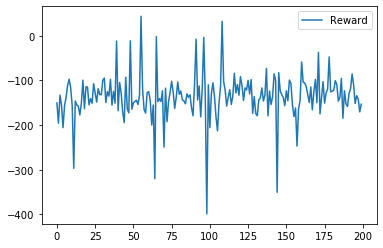

Complete


In [ ]:
rewards  = []
episodes = []

mb = fastprogress.master_bar(range(EPISODES))
mb.names = ['Reward']
for i_episode in mb: ######## ALL APISODES
    
    state = env.reset()
    accumulativeReward = 0
    for t in range(MAX_ITER_EPISODE): ######## ITERATE EPISODE TRANSITIONS
        
        action = policy_net.chooseAction(state)              # Select action from the agent
        next_state, reward, done, _ = env.step(action)       # Perform action in the enviroment
        memory.push(state, action, next_state, reward, done) # Store the transition in memory
        state = next_state                                   # Define next state
        accumulativeReward += reward                         # Store reward

        # If the playMemory has enough data, then optimize
        # Perform one step of the optimization (on the target network)
        if len(memory) >= BATCH_SIZE:
            optimize_model()
        
        if done:
            break
            
    
    # Update the target network, copying all weights and biases
    if i_episode % TARGET_UPDATE == 0:
        copyNet(source=policy_net, target=target_net)
        
    rewards.append(accumulativeReward)
    episodes.append(i_episode)
    
    # CHART
    graphs = [[episodes,rewards]]
    mb.update_graph(graphs)

print('Complete')

# Test agent in the enviroment

In [ ]:
state = env.reset()

for _ in range(1000):
    env.render()            
    action = policy_net.chooseAction(state)        # Select action from the agent
    next_state, reward, done, _ = env.step(action) # Perform action in the enviroment
    #memory.push(state, action, next_state, reward, done) # Store the transition in memory
    state = next_state                             # Define the next state
        
    if done:
        state = env.reset()
        
env.close()